<a href="https://colab.research.google.com/github/WilsonWang01/hands-on-gpt2/blob/main/training_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a miniGPT language model with JAX

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb"><img src="https://www.kaggle.com/static/images/logos/kaggle-logo-transparent-300.png" height="32" width="70"/>Run in Kaggle</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial demonstrates how to use JAX, [Flax NNX](http://flax.readthedocs.io) and [Optax](http://optax.readthedocs.io) for language model (pre)training using data and tensor [parallelism](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization) for [Single-Program Multi-Data](https://en.wikipedia.org/wiki/Single_program,_multiple_data)). It was originally inspired by the [Keras miniGPT tutorial](https://keras.io/examples/generative/text_generation_with_miniature_gpt/).

Here, you will learn how to:

- Define the miniGPT model with Flax and JAX automatic parallelism
- Load and preprocess the dataset
- Create the loss and training step functions
- Train the model on TPUs on Kaggle or Google Colab
- Profile for hyperparameter tuning

If you are new to JAX for AI, check out the [introductory tutorial](https://jax-ai-stack.readthedocs.io/en/latest/neural_net_basics.html), which covers neural network building with [Flax NNX](https://flax.readthedocs.io/en/latest/nnx_basics.html).

**Note:** If you are using [Kaggle](https://www.kaggle.com/), select the free TPU v5e-8 as the hardware accelerator. If you are using [Google Colab](https://colab.research.google.com/), select the free Google Cloud TPU v5e-1 as the hardware accelerator. You may also use Google Cloud TPUs.

Check the available JAX devices, or [`jax.Device`](https://jax.readthedocs.io/en/latest/_autosummary/jax.Device.html), with [`jax.devices()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.devices.html). The output of the cell below will show a list of 8 (eight) devices.

1、所有导入

In [1]:
import jax
import jax.numpy as jnp
from jax.sharding import NamedSharding, PartitionSpec, Mesh
from jax.experimental import mesh_utils
import flax.linen as nn
from flax.training import train_state
import optax
import numpy as np
from dataclasses import dataclass
from typing import List, Optional, Union
import grain.python as pygrain  # 数据加载
import orbax.checkpoint as ocp  # 检查点

# 验证TPU
print(f"JAX devices: {jax.devices()}")
print(f"Device count: {jax.device_count()}")

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
E0000 00:00:1769881153.164948   55908 common_lib.cc:650] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:238


JAX devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=4, process_index=0, coords=(0,2,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(1,2,0), core_on_chip=0), TpuDevice(id=6, process_index=0, coords=(0,3,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,3,0), core_on_chip=0)]
Device count: 8


2、超参数配置

In [26]:
@dataclass
class Config:
    """所有训练超参数"""
    # 模型架构 (TPU v3-8 优化版本)
    max_len: int = 256        # 512 → 256 (减少序列长度)
    embed_dim: int = 512      # 768 → 512 (减少嵌入维度)
    num_heads: int = 8        # 12 → 8 
    num_layers: int = 6       # 12 → 6 (减少层数)
    ff_dim: int = 2048        # 3072 → 2048
    dropout_rate: float = 0.1
    
    # 训练参数
    batch_size: int = 16      # 64 → 16 (关键！减少batch)
    learning_rate: float = 3e-4
    num_epochs: int = 10
    warmup_steps: int = 1000
    
    # 词表大小 (必须由tokenizer设置!)
    vocab_size: int = -1  # 运行tokenizer后自动更新

config = Config()
print(f"Config: {config}")

Config: Config(max_len=256, embed_dim=512, num_heads=8, num_layers=6, ff_dim=2048, dropout_rate=0.1, batch_size=16, learning_rate=0.0003, num_epochs=10, warmup_steps=1000, vocab_size=-1)


Tokenizer定义

In [31]:
class MultilingualTokenizer:
    """Yi-1.5 tokenizer wrapper (64K vocab), 支持中英文"""
    
    def __init__(self, model_name: str = "01-ai/Yi-1.5-6B"):
        from transformers import AutoTokenizer
        
        self._tokenizer = AutoTokenizer.from_pretrained(
            model_name, 
            trust_remote_code=True,
            use_fast=True
        )
        
        self._eot_token = self._tokenizer.eos_token_id
        self._bos_token = self._tokenizer.bos_token_id
        self._pad_token = self._tokenizer.pad_token_id if self._tokenizer.pad_token_id is not None else 0
        
        # TPU对齐: 词表必须能被128整除
        raw_vocab = len(self._tokenizer)
        self._padded_vocab = ((raw_vocab // 128) + 1) * 128 if raw_vocab % 128 != 0 else raw_vocab
    
    @property
    def n_vocab(self) -> int:
        return len(self._tokenizer)
    
    @property
    def padded_vocab_size(self) -> int:
        return self._padded_vocab
    
    @property
    def eot_token(self) -> int:
        return self._eot_token
    
    @property
    def pad_token(self) -> int:
        return self._pad_token
    
    def encode(self, text: str, allowed_special: Optional[set] = None, add_special_tokens: bool = False) -> List[int]:
        return self._tokenizer.encode(text, add_special_tokens=add_special_tokens)
    
    def decode(self, tokens: Union[List[int], int]) -> str:
        if isinstance(tokens, int):
            tokens = [tokens]
        return self._tokenizer.decode(tokens, skip_special_tokens=True)


def get_tokenizer(model_name: str = "01-ai/Yi-1.5-6B") -> MultilingualTokenizer:
    return MultilingualTokenizer(model_name)

初始化Tokenizer & 更新config

In [32]:
tokenizer = get_tokenizer()
config.vocab_size = tokenizer.padded_vocab_size

print(f"✓ Tokenizer loaded: vocab={tokenizer.n_vocab:,}, padded={config.vocab_size:,}")
assert config.vocab_size > 0, "❌ vocab_size未设置！请先运行tokenizer cell"

# 测试
test_text = "Hello 你好 Test测试"
tokens = tokenizer.encode(test_text)
print(f"'{test_text}' → {len(tokens)} tokens")

✓ Tokenizer loaded: vocab=63,992, padded=64,000
'Hello 你好 Test测试' → 5 tokens


模型架构

In [34]:
class TokenAndPositionEmbedding(nn.Module):
    """Token + Position Embedding"""
    vocab_size: int
    max_len: int
    embed_dim: int

    @nn.compact
    def __call__(self, x):
        seq_len = x.shape[1]
        positions = jnp.arange(seq_len)
        
        tok_emb = nn.Embed(self.vocab_size, self.embed_dim, name='token_emb')(x)
        pos_emb = nn.Embed(self.max_len, self.embed_dim, name='pos_emb')(positions)
        
        return tok_emb + pos_emb


class TransformerBlock(nn.Module):
    """单个Transformer块"""
    embed_dim: int
    num_heads: int
    ff_dim: int
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, x, training: bool = False):
        # Self-attention with causal mask
        attn_output = nn.SelfAttention(
            num_heads=self.num_heads,
            qkv_features=self.embed_dim,
            dropout_rate=self.dropout_rate,
            deterministic=not training,
            decode=False,
        )(x, mask=nn.make_causal_mask(jnp.ones((x.shape[0], x.shape[1]))))
        
        x = nn.LayerNorm()(x + attn_output)
        
        # FFN
        ffn_output = nn.Dense(self.ff_dim)(x)
        ffn_output = nn.gelu(ffn_output)
        ffn_output = nn.Dense(self.embed_dim)(ffn_output)
        ffn_output = nn.Dropout(self.dropout_rate, deterministic=not training)(ffn_output)
        
        x = nn.LayerNorm()(x + ffn_output)
        return x


class MiniGPT(nn.Module):
    """Mini-GPT 模型"""
    vocab_size: int
    max_len: int
    embed_dim: int
    num_heads: int
    num_layers: int
    ff_dim: int
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, x, training: bool = False):
        x = TokenAndPositionEmbedding(
            vocab_size=self.vocab_size,
            max_len=self.max_len,
            embed_dim=self.embed_dim
        )(x)
        
        for i in range(self.num_layers):
            x = TransformerBlock(
                embed_dim=self.embed_dim,
                num_heads=self.num_heads,
                ff_dim=self.ff_dim,
                dropout_rate=self.dropout_rate,
                name=f'transformer_block_{i}'
            )(x, training=training)
        
        # Language modeling head
        logits = nn.Dense(self.vocab_size, name='lm_head')(x)
        return logits


def create_model(config: Config):
    """创建模型实例"""
    return MiniGPT(
        vocab_size=config.vocab_size,
        max_len=config.max_len,
        embed_dim=config.embed_dim,
        num_heads=config.num_heads,
        num_layers=config.num_layers,
        ff_dim=config.ff_dim,
        dropout_rate=config.dropout_rate
    )

TPU Mesh & Sharding 设置

In [35]:
# 创建2D mesh 用于模型和数据并行
devices = mesh_utils.create_device_mesh((jax.device_count(),))
mesh = Mesh(devices, axis_names=('data',))

# 数据sharding: batch维度分布到所有设备
data_sharding = NamedSharding(mesh, PartitionSpec('data', None))
# 参数sharding: 复制到所有设备
replicated_sharding = NamedSharding(mesh, PartitionSpec())

print(f"Mesh created: {mesh}")

Mesh created: Mesh('data': 8, axis_types=(Auto,))


数据加载

In [38]:
class TextDataset(pygrain.RandomAccessDataSource):
    """简单文本数据集"""
    
    def __init__(self, texts: List[str], max_len: int = 512):
        super().__init__()
        self.texts = texts
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = tokenizer.encode(text)[:self.max_len]
        
        # Pad to max_len
        if len(tokens) < self.max_len:
            tokens = tokens + [tokenizer.pad_token] * (self.max_len - len(tokens))
        
        return {'input_ids': np.array(tokens, dtype=np.int32)}


def load_and_preprocess_data(batch_size: int):
    """加载数据并创建DataLoader"""
    # TODO: 替换为真实数据
    sample_texts = [
        "这是一个测试文本。" * 20,
        "This is a test sentence. " * 20,
        "中英混合 Mixed language text. " * 20,
    ] * 100  # 300个样本用于测试
    
    dataset = TextDataset(sample_texts, max_len=config.max_len)
    
    sampler = pygrain.IndexSampler(
        num_records=len(dataset),
        shuffle=True,
        seed=42,
        shard_options=pygrain.NoSharding(),
        num_epochs=1,
    )
    
    dataloader = pygrain.DataLoader(
        data_source=dataset,
        sampler=sampler,
        operations=[pygrain.Batch(batch_size, drop_remainder=True)],
        worker_count=4,
    )
    
    return dataloader

Loss & Training Step

In [40]:
def create_train_step(model):
    """创建train_step函数 (闭包捕获model)"""
    
    def loss_fn(params, batch, rng):
        """计算语言模型loss"""
        input_ids = batch['input_ids']
        
        # 预测下一个token (需要传入dropout rng)
        logits = model.apply(
            {'params': params}, 
            input_ids[:, :-1], 
            training=True,
            rngs={'dropout': rng}  # Flax dropout 需要 PRNG
        )
        targets = input_ids[:, 1:]
        
        # Cross-entropy loss
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets).mean()
        return loss

    @jax.jit
    def train_step(state, batch, rng):
        """单步训练"""
        loss, grads = jax.value_and_grad(loss_fn)(state.params, batch, rng)
        state = state.apply_gradients(grads=grads)
        return state, loss
    
    return train_step

模型初始化

In [44]:
# 创建模型
model = create_model(config)

# 初始化参数
rng = jax.random.PRNGKey(42)
dummy_input = jnp.ones((1, config.max_len), dtype=jnp.int32)
params = model.init(rng, dummy_input, training=False)['params']

# 优化器
tx = optax.adamw(config.learning_rate)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# 参数数量
param_count = sum(p.size for p in jax.tree_util.tree_leaves(params))
print(f"✓ Model initialized: {param_count/1e6:.1f}M parameters")

# 创建train_step函数 (闭包捕获model)
train_step = create_train_step(model)
print("✓ train_step created")


# =============================
# 文本生成函数 (用于可视化训练效果)
# =============================
def generate_text(params, prompt: str, max_new_tokens: int = 50, temperature: float = 1.0):
    """生成文本, 用于观察模型训练效果"""
    # 编码 prompt
    input_ids = jnp.array([tokenizer.encode(prompt)], dtype=jnp.int32)
    
    for _ in range(max_new_tokens):
        # 截断到 max_len
        if input_ids.shape[1] >= config.max_len:
            input_ids = input_ids[:, -config.max_len:]
        
        # 前向推理 (不使用dropout)
        logits = model.apply({'params': params}, input_ids, training=False)
        
        # 获取最后一个位置的logits
        next_token_logits = logits[0, -1, :] / temperature
        
        # 采样下一个token (贪婪采样)
        next_token = jnp.argmax(next_token_logits)
        
        # 追加到序列
        input_ids = jnp.concatenate([input_ids, next_token[None, None]], axis=1)
        
        # 如果生成了结束符，停止
        if next_token == tokenizer.eot_token:
            break
    
    # 解码
    return tokenizer.decode(input_ids[0].tolist())


# 测试 prompts
SAMPLE_PROMPTS = ["这是", "Hello", "The"]
print("✓ generate_text function ready")

✓ Model initialized: 84.6M parameters
✓ train_step created
✓ generate_text function ready


训练循环

In [45]:
print(f"\n{'='*50}")
print("Starting training...")
print(f"{'='*50}")

dataloader = load_and_preprocess_data(config.batch_size)

# 训练用的RNG
train_rng = jax.random.PRNGKey(0)

# 记录训练指标
metrics_history = {'train_loss': [], 'epoch_loss': []}

with mesh:
    for epoch in range(config.num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch in dataloader:
            # 转换为JAX array并shard
            batch = {k: jnp.array(v) for k, v in batch.items()}
            
            # 每步生成新的RNG (用于dropout)
            step_rng = jax.random.fold_in(train_rng, num_batches)
            
            state, loss = train_step(state, batch, step_rng)
            
            # 记录每步loss
            metrics_history['train_loss'].append(float(loss))
            
            epoch_loss += loss
            num_batches += 1
            
            if num_batches % 10 == 0:
                print(f"  Epoch {epoch+1}, Batch {num_batches}, Loss: {loss:.4f}")
        
        avg_loss = epoch_loss / max(num_batches, 1)
        metrics_history['epoch_loss'].append(float(avg_loss))
        print(f"Epoch {epoch+1}/{config.num_epochs} - Avg Loss: {avg_loss:.4f}")
        
        # 每个 epoch 结束时生成样例文本
        print(f"\n--- Epoch {epoch+1} Sample Generation ---")
        for prompt in SAMPLE_PROMPTS:
            generated = generate_text(state.params, prompt, max_new_tokens=30)
            print(f"  '{prompt}' → {generated}")
        print()
        
        # 每个epoch更新基础RNG
        train_rng = jax.random.fold_in(train_rng, epoch)

print("\n✓ Training complete!")
print(f"Final Loss: {metrics_history['train_loss'][-1]:.4f}")

# 最终生成展示
print("\n" + "="*50)
print("Final Model Generation:")
print("="*50)
for prompt in SAMPLE_PROMPTS:
    generated = generate_text(state.params, prompt, max_new_tokens=50)
    print(f"'{prompt}' → {generated}\n")


Starting training...
The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 1, Batch 10, Loss: 3.1539
Epoch 1/10 - Avg Loss: 4.1041

--- Epoch 1 Sample Generation ---
  '这是' → 这是..............................
  'Hello' → Hello测试测试测试测试测试测试测试测试测试测试测试测试测试测试测试测试测试测试测试测试测试测试文本文本文本文本文本文本文本文本
  'The' → The..............................

The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 2, Batch 10, Loss: 0.9858
Epoch 2/10 - Avg Loss: 1.1610

--- Epoch 2 Sample Generation ---
  '这是' → 这是..............................
  'Hello' → Hello..............................
  'The' → The..............................

The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 3, Batch 10, Loss: 0.8611
Epoch 3/10 - Avg Loss: 0.9214

--- Epoch 3 Sample Generation ---
  '这是' → 这是..............................
  'Hello' → Hello..............................
  'The' → The..............................

The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 4, Batch 10, Loss: 0.8220
Epoch 4/10 - Avg Loss: 0.8724

--- Epoch 4 Sample Generation ---
  '这是' → 这是..............................
  'Hello' → Hello..............................
  'The' → The..............................

The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 5, Batch 10, Loss: 0.7544
Epoch 5/10 - Avg Loss: 0.7979

--- Epoch 5 Sample Generation ---
  '这是' → 这是..............................
  'Hello' → Hello text................... text.... text....
  'The' → The..............................

The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 6, Batch 10, Loss: 0.3239
Epoch 6/10 - Avg Loss: 0.4327

--- Epoch 6 Sample Generation ---
  '这是' → 这是 a test sentence. This is a test sentence. This is a test sentence. 
  'Hello' → Hello混合 Mixed混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed
  'The' → The a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. 

The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 7, Batch 10, Loss: 0.0167
Epoch 7/10 - Avg Loss: 0.0290

--- Epoch 7 Sample Generation ---
  '这是' → 这是 is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This
  'Hello' → Hello混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text.
  'The' → The a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is

The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 8, Batch 10, Loss: 0.0035
Epoch 8/10 - Avg Loss: 0.0048

--- Epoch 8 Sample Generation ---
  '这是' → 这是 is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This
  'Hello' → Hello混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text.
  'The' → The a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is

The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 9, Batch 10, Loss: 0.0007
Epoch 9/10 - Avg Loss: 0.0012

--- Epoch 9 Sample Generation ---
  '这是' → 这是 a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is
  'Hello' → Hello混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text.
  'The' → The a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is

The OrderedVocab you are attempting to save contains holes for indices [3, 4, 5, 9, 10, 11, 12, 13], your vocabulary could be corrupted!


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not a

  Epoch 10, Batch 10, Loss: 0.0005
Epoch 10/10 - Avg Loss: 0.0008

--- Epoch 10 Sample Generation ---
  '这是' → 这是 is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This
  'Hello' → Hello混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text.
  'The' → The a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is


✓ Training complete!
Final Loss: 0.0005

Final Model Generation:
'这是' → 这是 is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a test sentence. This is a

'Hello' → Hello混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text. 中英混合 Mixed language text. 中英混合 M

'The' → The a test sentence. This is a test

Visualize the training loss.

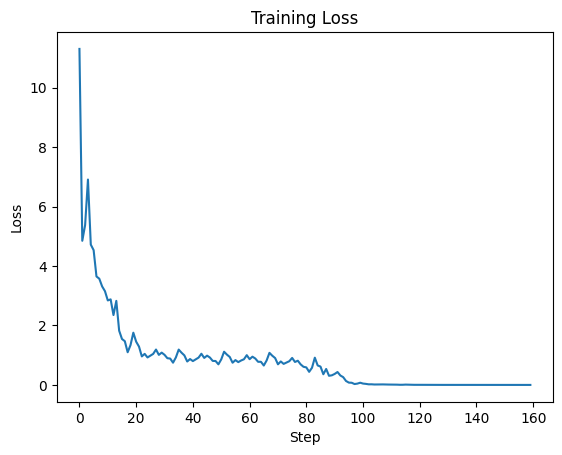

In [54]:
import matplotlib.pyplot as plt
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

保存检查点 (可选)

In [58]:
# 保存模型
import orbax.checkpoint as ocp

checkpointer = ocp.PyTreeCheckpointer()
checkpointer.save('/kaggle/working/checkpoint', state, force=True)  # force=True 覆盖已存在
print("✓ Checkpoint saved to /kaggle/working/checkpoint")

✓ Checkpoint saved to /kaggle/working/checkpoint


上传到 HuggingFace Hub

In [59]:
# Step 1: 安装依赖 (如果未安装)
# !pip install -q huggingface_hub

from huggingface_hub import HfApi, login, create_repo

# Step 2: 登录 HuggingFace (需要 Access Token)
# 方法1: 使用 Kaggle Secrets
from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()
hf_token = secrets.get_secret("HF_TOKEN")  # 在 Kaggle Secrets 中添加 HF_TOKEN
login(token=hf_token)

# 方法2: 直接输入 (不推荐)
# login(token="hf_xxxx")

# Step 3: 设置仓库信息
REPO_NAME = "handsongpt2"  # 修改为你的仓库名
USERNAME = "Wilsonwin"       # 修改为你的 HuggingFace 用户名
REPO_ID = f"{USERNAME}/{REPO_NAME}"

# Step 4: 创建仓库 (如果不存在)
api = HfApi()
try:
    create_repo(REPO_ID, repo_type="model", exist_ok=True)
    print(f"✓ Repository created/found: https://huggingface.co/{REPO_ID}")
except Exception as e:
    print(f"Repo creation: {e}")

# Step 5: 创建模型卡 (README)
model_card = f"""---
language:
- zh
- en
license: apache-2.0
tags:
- jax
- flax
- mini-gpt
- text-generation
---

# {REPO_NAME}

HandsOnGPT2 model trained on GuoFeng Webnovel Corpus using JAX/Flax on Kaggle TPU.

## Model Details

- **Architecture**: GPT-2 style transformer
- **Parameters**: {param_count/1e6:.1f}M
- **Vocab Size**: {config.vocab_size:,} (Yi-1.5 tokenizer, TPU-aligned)
- **Max Length**: {config.max_len}
- **Layers**: {config.num_layers}
- **Hidden Size**: {config.embed_dim}
- **Attention Heads**: {config.num_heads}

## Training

- **Framework**: JAX/Flax
- **Hardware**: Kaggle TPU v3-8
- **Batch Size**: {config.batch_size}
- **Learning Rate**: {config.learning_rate}
- **Final Loss**: {metrics_history['train_loss'][-1]:.4f}

## Usage

```python
import orbax.checkpoint as ocp

checkpointer = ocp.PyTreeCheckpointer()
state = checkpointer.restore('/path/to/checkpoint')
```

## License

Apache 2.0
"""

# 保存模型卡
with open('/kaggle/working/README.md', 'w') as f:
    f.write(model_card)

# Step 6: 上传文件
api.upload_folder(
    folder_path='/kaggle/working/checkpoint',
    repo_id=REPO_ID,
    repo_type="model",
    path_in_repo="checkpoint",
)

api.upload_file(
    path_or_fileobj='/kaggle/working/README.md',
    path_in_repo='README.md',
    repo_id=REPO_ID,
    repo_type="model",
)

print(f"\n✓ Model uploaded to: https://huggingface.co/{REPO_ID}")
print("Check your HuggingFace dashboard!")

✓ Repository created/found: https://huggingface.co/Wilsonwin/handsongpt2


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            


✓ Model uploaded to: https://huggingface.co/Wilsonwin/handsongpt2
Check your HuggingFace dashboard!


### download web_novel dataset from dropbox

In [ ]:
import os
import json
import zipfile

# 1. 下载 GuoFeng Corpus (Dropbox)
print("⬇️ Downloading GuoFeng Webnovel Corpus...")
!wget -O webnovel_data.zip "https://www.dropbox.com/scl/fo/dtrf3pe1vfbo5nse16648/AAZ5SFnuwohj7IJ2J-Q8zHs?rlkey=486vbn17qra1ez91btj0n4xu2&e=1&dl=1"

# 2. 解压
print("📂 Unzipping...")
with zipfile.ZipFile("webnovel_data.zip", 'r') as zip_ref:
    zip_ref.extractall("webnovel_raw")

# 3. 转换为 JSONL
output_file = "/kaggle/working/webnovel_train.jsonl"
source_zh = None
source_en = None

# 自动寻找解压后藏在深层目录里的文件
for root, dirs, files in os.walk("webnovel_raw"):
    if "train.zh" in files: source_zh = os.path.join(root, "train.zh")
    if "train.en" in files: source_en = os.path.join(root, "train.en")

if source_zh and source_en:
    print(f"✅ Found source files:\n  ZH: {source_zh}\n  EN: {source_en}")
    
    with open(source_zh, 'r', encoding='utf-8') as f_zh, \
         open(source_en, 'r', encoding='utf-8') as f_en, \
         open(output_file, 'w', encoding='utf-8') as f_out:
        
        count = 0
        for line_zh, line_en in zip(f_zh, f_en):
            zh_text = line_zh.strip()
            en_text = line_en.strip()
            if not zh_text or not en_text: continue
            
            # 格式：中文 + 换行 + 英文
            # 这样训练出来的模型，给它中文，它就会预测出英文翻译
            record = { "text": f"{zh_text}\n{en_text}" }
            
            f_out.write(json.dumps(record, ensure_ascii=False) + '\n')
            count += 1
            
    print(f"🎉 Done! Processed {count} lines. File saved at: {output_file}")
else:
    print("❌ Error: Could not find train.zh or train.en files.")

In [ ]:
# Download & Process the Data for JAX
import os
import json
import zipfile
# 1. Download the GuoFeng Corpus directly
# We use the 'dl=1' flag to get the file directly
print("⬇️ Downloading GuoFeng Webnovel Corpus...")
!wget -O webnovel_data.zip "https://www.dropbox.com/scl/fo/dtrf3pe1vfbo5nse16648/AAZ5SFnuwohj7IJ2J-Q8zHs?rlkey=486vbn17qra1ez91btj0n4xu2&e=1&dl=1"
# 2. Unzip
print("📂 Unzipping...")
with zipfile.ZipFile("webnovel_data.zip", 'r') as zip_ref:
    zip_ref.extractall("webnovel_raw")
# 3. Convert to JSONL (JAX friendly format)
# We will combine train.zh (Chinese) and train.en (English)
# into a format where the model learns to translate or associate pairs.
final_output_file = "/content/webnovel_train.jsonl"
source_zh = "webnovel_raw/V1/TRAIN/train.zh"
source_en = "webnovel_raw/V1/TRAIN/train.en"
# Verify path logic (in case unzip structure varies)
# Sometimes dropbox zips create a top-level folder. We search for the files.
found_zh = None
found_en = None
for root, dirs, files in os.walk("webnovel_raw"):
    if "train.zh" in files: found_zh = os.path.join(root, "train.zh")
    if "train.en" in files: found_en = os.path.join(root, "train.en")
if found_zh and found_en:
    print(f"✅ Found source files:\n  ZH: {found_zh}\n  EN: {found_en}")

    print("🔄 converting to JSONL...")
    with open(found_zh, 'r', encoding='utf-8') as f_zh, \
         open(found_en, 'r', encoding='utf-8') as f_en, \
         open(final_output_file, 'w', encoding='utf-8') as f_out:

        count = 0
        for line_zh, line_en in zip(f_zh, f_en):
            zh_text = line_zh.strip()
            en_text = line_en.strip()
            if not zh_text or not en_text: continue

            # --- CHOOSE YOUR TRAINING FORMAT HERE ---

            # OPTION A: Translation (Instruction Tuning style)
            # Use this if your model supports 'instruction' fields
            # record = {
            #     "instruction": "Translate chinese to english",
            #     "input": zh_text,
            #     "output": en_text
            # }
            # OPTION B: Raw Text (Pretraining style)
            # Use this if you are doing standard Causal Language Modeling
            # The model just sees the Chinese followed by English
            record = {
                "text": f"{zh_text}\n{en_text}"
            }

            f_out.write(json.dumps(record, ensure_ascii=False) + '\n')
            count += 1

    print(f"🎉 Done! Created {final_output_file} with {count} examples.")
else:
    print("❌ Could not find train.zh or train.en inside the zip.")